In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Compose, ToTensor

import numpy as np

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, n_latent_features):
        
        super(Encoder, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        
        # можно попробовать разворачивать в 1d вектор
        # и нормализовать с помощью BatchNorm1d 
        # вместо BatchNorm2d без доп. Linear слоя
        
        self.fc = nn.Sequential(nn.Linear(256*4*4, n_latent_features), nn.ReLU(), nn.BatchNorm1d(n_latent_features))
        
        self.fc_mu = nn.Linear(n_latent_features, n_latent_features)
        self.fc_logvar = nn.Linear(n_latent_features, n_latent_features)
        
    def forward(self, x):
        x = self.conv(x)
        
        x = x.reshape(-1, 256*4*4)
        
        x = self.fc(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar
    
class Decoder(nn.Module):
    
    def __init__(self, n_latent_features):
        
        super(Decoder, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(n_latent_features, 256*4*4), 
            nn.ReLU(), 
        )
    
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(256, 128, 3, padding=1), 
            nn.ReLU(), 
            nn.BatchNorm2d(128),
            
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(128, 64, 3, padding=1), 
            nn.ReLU(), 
            
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        
        x = x.reshape(-1, 256, 4, 4)
        
        x = self.conv(x)
        
        return x
    
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, n_latent_features):
        
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = Encoder(n_latent_features)
        
        self.decoder = Decoder(n_latent_features)
        
    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        
        return mu + eps * std
    
    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        
        x = self.reparameterize(mu, logvar)

        x = self.decoder(x)
        
        return x, mu, logvar

In [7]:
def KLD(mu, logvar):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= int(np.product(image_shape) * batch_size)
    return kld

def train_for_one_epoch(model, optimizer, loader, rec_criterion, use_gpu=False):

    losses = []

    for x, y in loader:
        
        if use_gpu:
            x, y = x.cuda(), y.cuda()
        
        rec_x, mu, logvar = model(x)
        
        rec_loss = rec_criterion(rec_x, x)
        kld_loss = KLD(mu, logvar)
        loss = rec_loss + kld_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        
    mean_loss = np.mean(losses)
    
    return mean_loss

def train_autoencoder(n_latent_features, train_rec_criterion, train_loader, 
                      image_shape, n_epochs=100, use_gpu=True):

    
    model = VariationalAutoencoder(n_latent_features)
    
    if use_gpu:
        model = model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    
    for epoch in range(n_epochs):
        mean_loss = train_for_one_epoch(model, optimizer, train_loader, train_rec_criterion, use_gpu=use_gpu)
        print(f'epoch #{epoch} mean train loss: {mean_loss:.3f}')
            
    return model

In [8]:
image_shape = (3, 32, 32)
batch_size = 128

In [9]:
transform = Compose([ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
model_20 = train_autoencoder(
    n_latent_features=20, train_rec_criterion=torch.nn.BCELoss(), 
    train_loader=train_loader, n_epochs=15, image_shape=image_shape, 
    use_gpu=True
)

epoch #0 mean train loss: 0.636
epoch #1 mean train loss: 0.613
epoch #2 mean train loss: 0.608
epoch #3 mean train loss: 0.605
epoch #4 mean train loss: 0.604
epoch #5 mean train loss: 0.603
epoch #6 mean train loss: 0.603
epoch #7 mean train loss: 0.602
epoch #8 mean train loss: 0.602
epoch #9 mean train loss: 0.601
epoch #10 mean train loss: 0.601
epoch #11 mean train loss: 0.601
epoch #12 mean train loss: 0.601
epoch #13 mean train loss: 0.600
epoch #14 mean train loss: 0.600


In [11]:
model_100 = train_autoencoder(
    n_latent_features=100, train_rec_criterion=torch.nn.BCELoss(), 
    train_loader=train_loader, n_epochs=15, image_shape=image_shape, 
    use_gpu=True
)

epoch #0 mean train loss: 0.622
epoch #1 mean train loss: 0.606
epoch #2 mean train loss: 0.600
epoch #3 mean train loss: 0.598
epoch #4 mean train loss: 0.597
epoch #5 mean train loss: 0.596
epoch #6 mean train loss: 0.595
epoch #7 mean train loss: 0.595
epoch #8 mean train loss: 0.595
epoch #9 mean train loss: 0.595
epoch #10 mean train loss: 0.594
epoch #11 mean train loss: 0.594
epoch #12 mean train loss: 0.594
epoch #13 mean train loss: 0.594
epoch #14 mean train loss: 0.594


In [12]:
import matplotlib.pyplot as plt

In [13]:
num_images = 20

test_images = []
test_labels = []

for i in range(num_images):
    x, y = test_dataset[i]
    test_images.append(x)
    test_labels.append(y)

test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

In [14]:
def plot_reconstructed_images_over_actual(models, images, labels):
    
    classes = np.array(('plane', 'car', 'bird', 'cat',
                    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))
    
    x = images.cuda()
    
    xs_numpy = []
    rec_xs_numpy = []
    
    for _, model in models:
        rec_x = model.decode(model.encode(x))
        x_numpy = x.cpu().detach().numpy()
        rec_x_numpy = rec_x.cpu().detach().numpy()
        
        xs_numpy.append(x_numpy)
        rec_xs_numpy.append(rec_x_numpy)
    
    nrows, ncols = len(images), 1 + len(models)
    fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

    for i, (x, y) in enumerate(zip(x, labels)):
        ax[i][0].imshow(np.transpose(x_numpy[i], (1, 2, 0)))
        ax[i][0].set_title(f'actual {classes[y]}')
        ax[i][0].set_xticks([])
        ax[i][0].set_yticks([])
        
        for model_number, (model_name, model) in enumerate(models):
            ax[i][1+model_number].imshow(np.transpose(rec_xs_numpy[model_number][i], (1, 2, 0)))
            ax[i][1+model_number].set_title(f'{model_name} output')
            ax[i][1+model_number].set_xticks([])
            ax[i][1+model_number].set_yticks([])

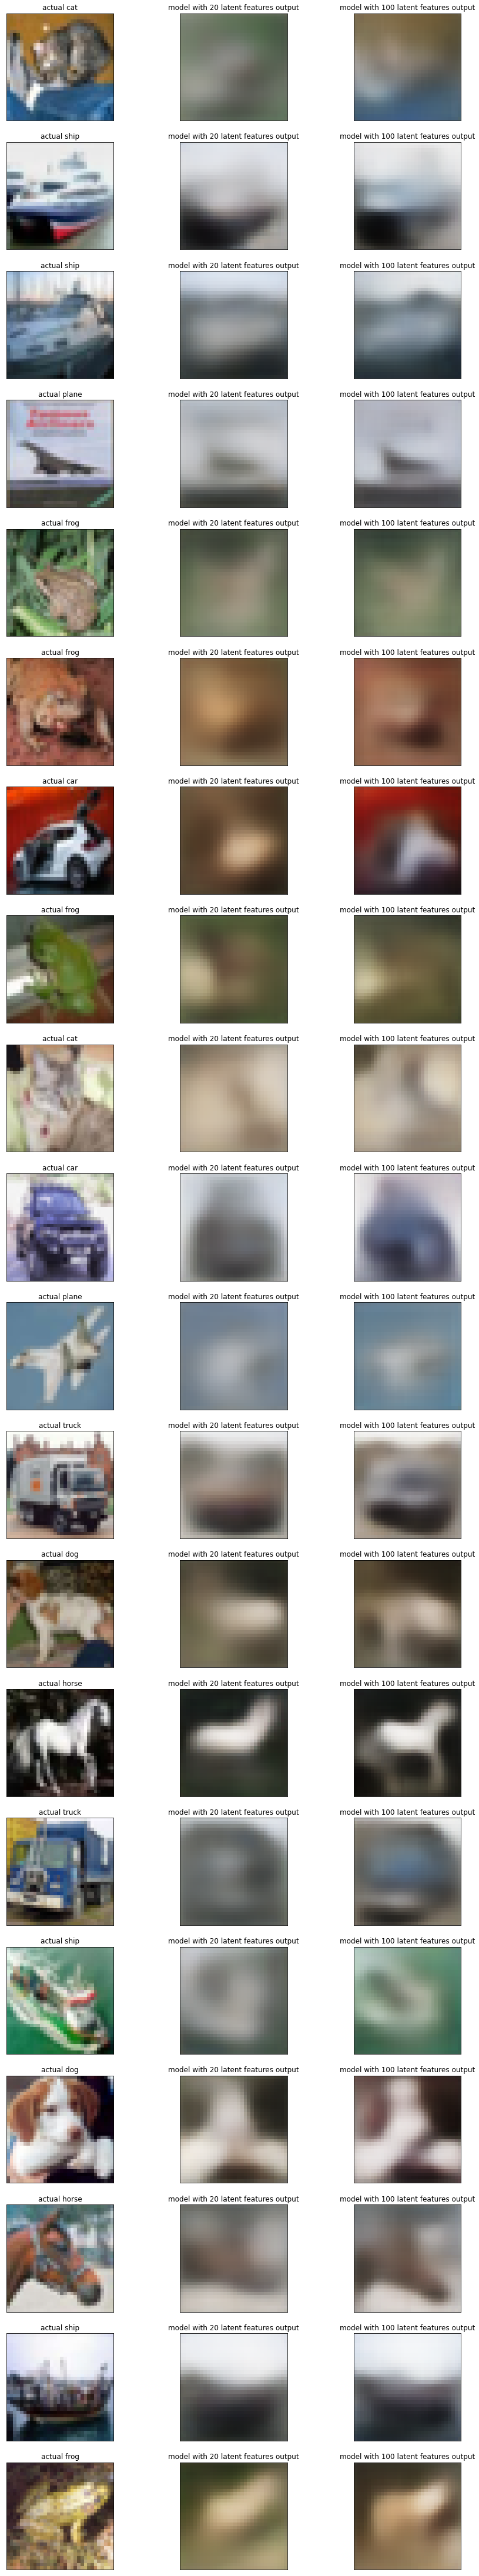

In [15]:
models = [('model with 20 latent features', model_20), ('model with 100 latent features', model_100)]

for _, model in models:
    model.eval()

plot_reconstructed_images_over_actual(models, test_images, test_labels)